# Introduction
Welcome to Practical 4 for Graph Representation Learning. In this practical, we will focus on the over-smoothing phenomenon described in the lectures. We will be using [PyTorch](https://pytorch.org/docs/stable/index.html) and [PyG](https://pytorch-geometric.readthedocs.io/en/latest/) for our experiments.

The notebook is divided into sections, each of which comes with complete or partially completed code. Before each snippet of code there will be a description of what we are about to implement. The sections of code you need to complete are marked as **Tasks**.

Please ensure that you operate within the framework given in the notebook and bring any questions you may have to the practical demonstrators. We suggest that you **DO NOT** edit code that is a part of the framework, since this will make it more difficult for demonstrators to assist if your code is broken.

Since we are working in a Jupyter Notebook, the code is very interactive. When you're stuck on something, try adding a new block of code below what you're working on and using it to debug your code.

###Part 0. Set up dependencies
Run the following blocks of code to install the required packages.

In [ ]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [ ]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Part 1. Oversmoothing

This part aims to investigate oversmoothing: we will consider different number of layers and visualise the corresponding node embeddings. Specifically, we will experiment using the following dataset and methods::

1.   Dataset: CORA
2.   Model: Graph Convolutional Network
3.   Dimensionality reduction method: T-SNE

### A. Model Implementation and Training

#### a. Import required packages

Please run the below code block to import the required python packages. It is recommended to use `GCNConv` layer from `torch_geometric.nn` as we had already implemented GNN from scratch in **Practical 2**. If you prefer to use your own GCN layer, please make sure it works within the pre-defined framework below.

In [ ]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:98: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

b. Load CORA dataset

We will use `torch_geometric.datasets` to load the `Cora` dataset for node classification, which consists of 2,708 nodes, 10,556 edges, 1,433 features, and 7 classes.

In [ ]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


`dataset.data.x` : input node features

`dataset.data.edge_index` : A sparce adjacent matrix with the size of *2 x n_edge*.
`dataset.data.y` : target labels

`dataset.data.train_mask` : boolean mask indicating whether an index belongs to training data

`dataset.data.val_mask` : boolean mask indicating whether an index belongs to validation data

`dataset.data.test_mask` : boolean mask indicating whether an index belongs to test data

#### c. Task 1) Setup graph convolutional network for node classification
Define a GCN class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hid_dim: int,
        n_classes: int,
        n_layers: int,
        dropout_ratio: float = 0.3):
        super(GCN, self).__init__()

        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        self.layers = nn.ModuleList()
        if n_layers > 0:
            self.layers.append(GCNConv(input_dim, hid_dim))

            for _ in range(n_layers - 1):
                self.layers.append(GCNConv(hid_dim, hid_dim))

            self.layers.append(GCNConv(hid_dim, n_classes))
        else:
            self.fc = nn.Linear(input_dim, n_classes)

    def forward(self, X, A) -> torch.Tensor:
        if self.n_layers == 0:
            return self.fc(X)

        for i, layer in enumerate(self.layers[:-1]):
            X = layer(X, A)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)

        logits = self.layers[-1](X, A)
        return logits

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        if self.n_layers == 0:
            return self.fc(X)

        for layer in self.layers[:-1]:
            X = layer(X, A)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)

        return X

    def param_init(self):
        if self.n_layers == 0:
            nn.init.xavier_uniform_(self.fc.weight)
            nn.init.zeros_(self.fc.bias)
        else:
            for layer in self.layers:
                if isinstance(layer, GCNConv):
                    nn.init.xavier_uniform_(layer.lin.weight)
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)


#### c. Task 2) Implement `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

Please note that `train` function should return the trained model object and `evaluate` function should return a validation accuracy.

In [ ]:
def train(params: typing.Dict) -> torch.nn.Module:

    device = "cuda" if torch.cuda.is_available() else "cpu"

    data = dataset.data
    data = data.to(device)

    params["n_classes"] = dataset.num_classes
    params["input_dim"] = dataset.num_features

    if params['model_name'] == 'GCN':
        model = GCN(
            params["input_dim"],
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'SkipGCN':
        model = SkipGCN(
            params["input_dim"],
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'JumpKnowGCN':
        model = JumpKnowGCN(
            params["input_dim"],
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    else:
        raise NotImplementedError
    model.param_init()

    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    loss_fn = nn.CrossEntropyLoss()

    patience = 0
    best_val_acc = 0
    best_model = None

    for epoch in range(params["epochs"]):
        model.train()
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)

        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        val_acc = evaluate(model, data, data.val_mask)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
            patience = 0
        else:
            patience += 1

        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc:.4f}")

        if patience >= params["max_patience"]:
            print("Early stopping triggered!")
            break

    if best_model is not None:
        model.load_state_dict(best_model)

    return model


In [ ]:
def evaluate(model, data, mask):

    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)

        preds = logits[mask].argmax(dim=1)
        labels = data.y[mask]

        accuracy = (preds == labels).sum().item() / mask.sum().item()

    return accuracy


#### d. Set training hyper-parameters

In [ ]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GCN"
}


#### e. Train 4 GCN models with 0, 1, 3 and 10 layers.

In [ ]:
torch.manual_seed(123) # set seed

In [ ]:
training_params["n_layers"] = 0
model_0_layer = train(training_params)

Epoch 1, Loss: 1.9578, Validation Accuracy: 0.1860
Epoch 2, Loss: 1.8554, Validation Accuracy: 0.2240
Epoch 3, Loss: 1.7555, Validation Accuracy: 0.2840
Epoch 4, Loss: 1.6584, Validation Accuracy: 0.3260
Epoch 5, Loss: 1.5643, Validation Accuracy: 0.3520
Epoch 6, Loss: 1.4733, Validation Accuracy: 0.3700
Epoch 7, Loss: 1.3858, Validation Accuracy: 0.3820
Epoch 8, Loss: 1.3018, Validation Accuracy: 0.4060
Epoch 9, Loss: 1.2216, Validation Accuracy: 0.4180
Epoch 10, Loss: 1.1453, Validation Accuracy: 0.4360
Epoch 11, Loss: 1.0730, Validation Accuracy: 0.4380
Epoch 12, Loss: 1.0048, Validation Accuracy: 0.4440
Epoch 13, Loss: 0.9406, Validation Accuracy: 0.4500
Epoch 14, Loss: 0.8804, Validation Accuracy: 0.4500
Epoch 15, Loss: 0.8242, Validation Accuracy: 0.4480
Epoch 16, Loss: 0.7718, Validation Accuracy: 0.4460
Epoch 17, Loss: 0.7231, Validation Accuracy: 0.4520
Epoch 18, Loss: 0.6780, Validation Accuracy: 0.4560
Epoch 19, Loss: 0.6363, Validation Accuracy: 0.4580
Epoch 20, Loss: 0.597

In [ ]:
training_params["n_layers"] = 1
model_1_layer = train(training_params)

Epoch 1, Loss: 1.9547, Validation Accuracy: 0.5280
Epoch 2, Loss: 1.8152, Validation Accuracy: 0.7080
Epoch 3, Loss: 1.6679, Validation Accuracy: 0.7640
Epoch 4, Loss: 1.4949, Validation Accuracy: 0.8000
Epoch 5, Loss: 1.3119, Validation Accuracy: 0.8040
Epoch 6, Loss: 1.1631, Validation Accuracy: 0.7960
Epoch 7, Loss: 0.9884, Validation Accuracy: 0.8020
Epoch 8, Loss: 0.8525, Validation Accuracy: 0.7940
Epoch 9, Loss: 0.7095, Validation Accuracy: 0.7980
Epoch 10, Loss: 0.5979, Validation Accuracy: 0.7960
Early stopping triggered!


In [ ]:
training_params["n_layers"] = 3
model_3_layer = train(training_params)

Epoch 1, Loss: 1.9472, Validation Accuracy: 0.4080
Epoch 2, Loss: 1.9048, Validation Accuracy: 0.4540
Epoch 3, Loss: 1.8472, Validation Accuracy: 0.5080
Epoch 4, Loss: 1.7603, Validation Accuracy: 0.5660
Epoch 5, Loss: 1.6301, Validation Accuracy: 0.6600
Epoch 6, Loss: 1.4816, Validation Accuracy: 0.7260
Epoch 7, Loss: 1.3126, Validation Accuracy: 0.7720
Epoch 8, Loss: 1.1126, Validation Accuracy: 0.7840
Epoch 9, Loss: 0.9011, Validation Accuracy: 0.7900
Epoch 10, Loss: 0.7182, Validation Accuracy: 0.8020
Epoch 11, Loss: 0.5470, Validation Accuracy: 0.8040
Epoch 12, Loss: 0.4296, Validation Accuracy: 0.7920
Epoch 13, Loss: 0.2909, Validation Accuracy: 0.8040
Epoch 14, Loss: 0.2611, Validation Accuracy: 0.7860
Epoch 15, Loss: 0.1408, Validation Accuracy: 0.7720
Epoch 16, Loss: 0.1292, Validation Accuracy: 0.7880
Early stopping triggered!


In [ ]:
training_params["n_layers"] = 10
model_10_layer = train(training_params)

Epoch 1, Loss: 1.9460, Validation Accuracy: 0.1220
Epoch 2, Loss: 1.9455, Validation Accuracy: 0.1340
Epoch 3, Loss: 1.9446, Validation Accuracy: 0.1340
Epoch 4, Loss: 1.9446, Validation Accuracy: 0.1220
Epoch 5, Loss: 1.9425, Validation Accuracy: 0.1220
Epoch 6, Loss: 1.9402, Validation Accuracy: 0.1220
Epoch 7, Loss: 1.9330, Validation Accuracy: 0.1320
Early stopping triggered!


### B. Visualisation

We will generate node embeddings, reduce their dimensions, and finally visualsie these embeddings: we expect to empirically observe that the embeddings become more and more similar with more layers.

Please use the **validation dataset** for the visualisation.

#### a. Import required packages

In [ ]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

#### b. Task 3) Implement a function for demensionality reduction

- The `dimension_reduction` function will take a model object and data, perform T-SNE, and return a *DataFrame* that contains reduced variables and labels for each data point.
- Please reduce the dimension to 2d.
- Use validation data for the visualisation

** You may refer this address below using T-SNE:
[Link to sklearn T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE


def dimension_reduction(model: nn.Module) -> pd.DataFrame:
    """
    Args:
        model: model object for generating features

    Returns:
        pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as columns
    """
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = dataset.data.to(device)

    with torch.no_grad():
        embeddings = model.generate_node_embeddings(data.x, data.edge_index)

    val_embeddings = embeddings[data.val_mask].cpu().numpy()
    val_labels = data.y[data.val_mask].cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(val_embeddings)

    df = pd.DataFrame({
        "dimension 1": reduced_embeddings[:, 0],
        "dimension 2": reduced_embeddings[:, 1],
        "labels": val_labels
    })

    return df


#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

#### d. Task 4) Implement a function for the visualisation and draw scatter plots

- Using `matplotlib` package is recommended, but you may use any other tool.
- Please refer to this page if you are not familar with the visualisation tool: [Link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

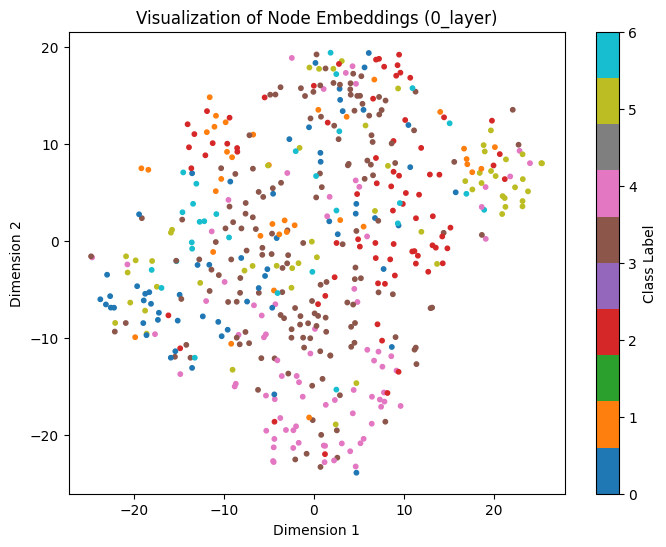

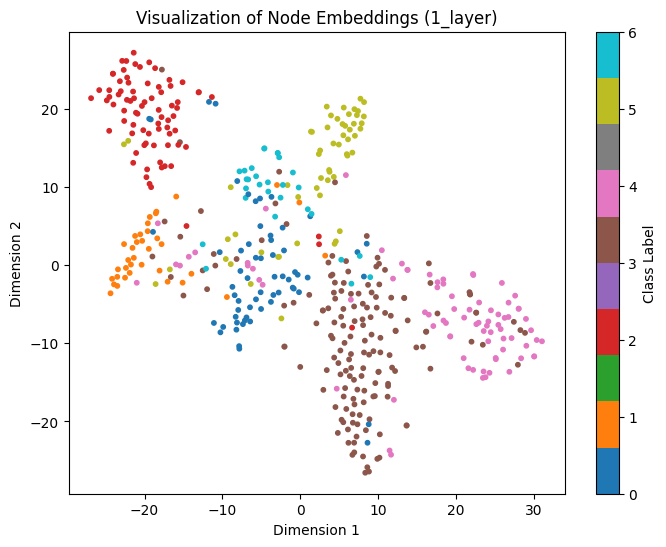

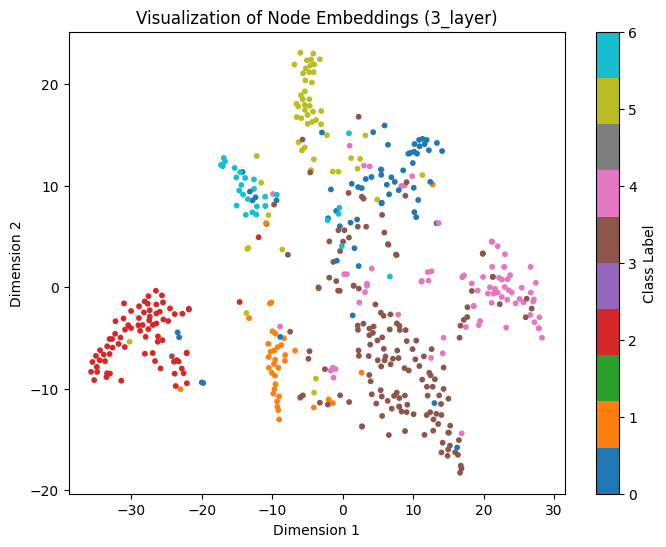

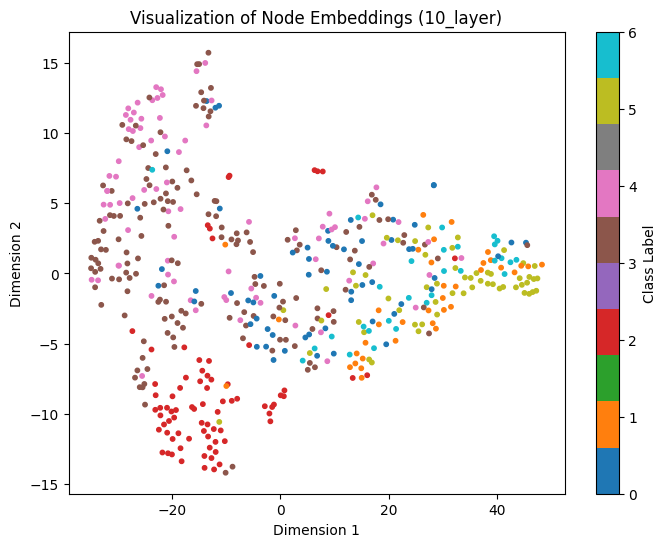

In [ ]:
def visualise(feature_dict: typing.Dict) -> None:

    for model_name, df in feature_dict.items():
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            df["dimension 1"],
            df["dimension 2"],
            c=df["labels"],
            cmap="tab10",
            s=10
        )
        plt.colorbar(scatter, label="Class Label")
        plt.title(f"Visualization of Node Embeddings ({model_name})")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()

visualise(feature_dict)


In [ ]:
visualise(feature_dict)

## Part 2. Skip-Connections

In this section, we will investigate whether skip-connections can alleviate the effect of over-smoothing.

#### a. Task 5) Setup graph convolutional network with skip-connections
Define a SkipGCN class for node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using **residual connection** is recommended, but you may also use other techniques, like **concatenation**.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [ ]:
class SkipGCN(nn.Module):
    def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
        super(SkipGCN, self).__init__()
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        self.layers = nn.ModuleList()
        if n_layers > 0:
            self.layers.append(GCNConv(input_dim, hid_dim))
            for _ in range(n_layers - 1):
                self.layers.append(GCNConv(hid_dim, hid_dim))
            self.layers.append(GCNConv(hid_dim, n_classes))
        else:
            self.fc = nn.Linear(input_dim, n_classes)

        self.concat_transforms = nn.ModuleList()
        for i in range(n_layers):
            concat_dim = input_dim + (i + 1) * hid_dim  # Dynamically calculate concatenated dimension
            self.concat_transforms.append(nn.Linear(concat_dim, hid_dim))

        self.norms = nn.ModuleList([nn.LayerNorm(hid_dim) for _ in range(n_layers)])

    def forward(self, X, A) -> torch.Tensor:
        if self.n_layers == 0:
            return self.fc(X)

        residuals = [X]
        for i, layer in enumerate(self.layers[:-1]):
            X = layer(X, A)
            residuals.append(X)
            concatenated = torch.cat(residuals, dim=-1)
            X = self.concat_transforms[i](concatenated)
            X = self.norms[i](X)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)

        logits = self.layers[-1](X, A)
        return logits

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        if self.n_layers == 0:
            return self.fc(X)

        residuals = [X]
        for i, layer in enumerate(self.layers[:-1]):
            X = layer(X, A)
            residuals.append(X)
            concatenated = torch.cat(residuals, dim=-1)
            X = self.concat_transforms[i](concatenated)
            X = self.norms[i](X)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)

        return X

    def param_init(self):
        if self.n_layers == 0:
            nn.init.xavier_uniform_(self.fc.weight)
            nn.init.zeros_(self.fc.bias)
        else:
            for layer in self.layers:
                if isinstance(layer, GCNConv):
                    nn.init.xavier_uniform_(layer.lin.weight)
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)

            for transform in self.concat_transforms:
                if isinstance(transform, nn.Linear):
                    nn.init.xavier_uniform_(transform.weight)
                    nn.init.zeros_(transform.bias)


#### b. Repeat experiments and Visualise the embeddings

In [ ]:
torch.manual_seed(123) # set seed

In [ ]:
training_params['model_name'] = 'SkipGCN'

training_params["n_layers"] = 0
model_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer = train(training_params)

training_params["n_layers"] = 3
model_3_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer = train(training_params)

Epoch 1, Loss: 1.9578, Validation Accuracy: 0.1860
Epoch 2, Loss: 1.8554, Validation Accuracy: 0.2240
Epoch 3, Loss: 1.7555, Validation Accuracy: 0.2840
Epoch 4, Loss: 1.6584, Validation Accuracy: 0.3260
Epoch 5, Loss: 1.5643, Validation Accuracy: 0.3520
Epoch 6, Loss: 1.4733, Validation Accuracy: 0.3700
Epoch 7, Loss: 1.3858, Validation Accuracy: 0.3820
Epoch 8, Loss: 1.3018, Validation Accuracy: 0.4060
Epoch 9, Loss: 1.2216, Validation Accuracy: 0.4180
Epoch 10, Loss: 1.1453, Validation Accuracy: 0.4360
Epoch 11, Loss: 1.0730, Validation Accuracy: 0.4380
Epoch 12, Loss: 1.0048, Validation Accuracy: 0.4440
Epoch 13, Loss: 0.9406, Validation Accuracy: 0.4500
Epoch 14, Loss: 0.8804, Validation Accuracy: 0.4500
Epoch 15, Loss: 0.8242, Validation Accuracy: 0.4480
Epoch 16, Loss: 0.7718, Validation Accuracy: 0.4460
Epoch 17, Loss: 0.7231, Validation Accuracy: 0.4520
Epoch 18, Loss: 0.6780, Validation Accuracy: 0.4560
Epoch 19, Loss: 0.6363, Validation Accuracy: 0.4580
Epoch 20, Loss: 0.597

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

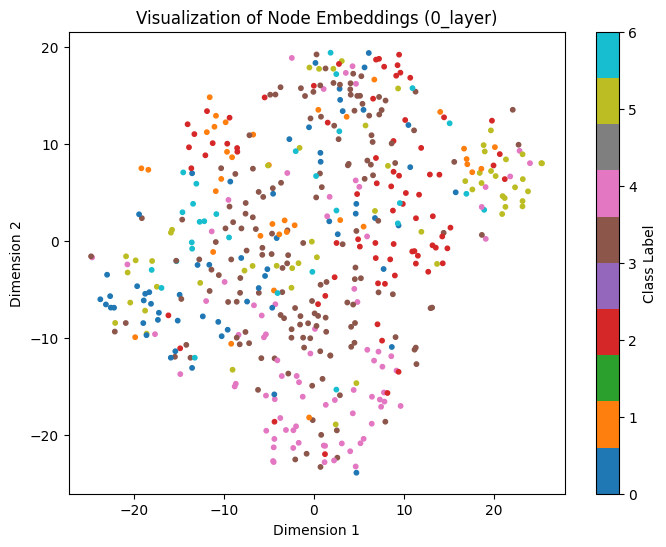

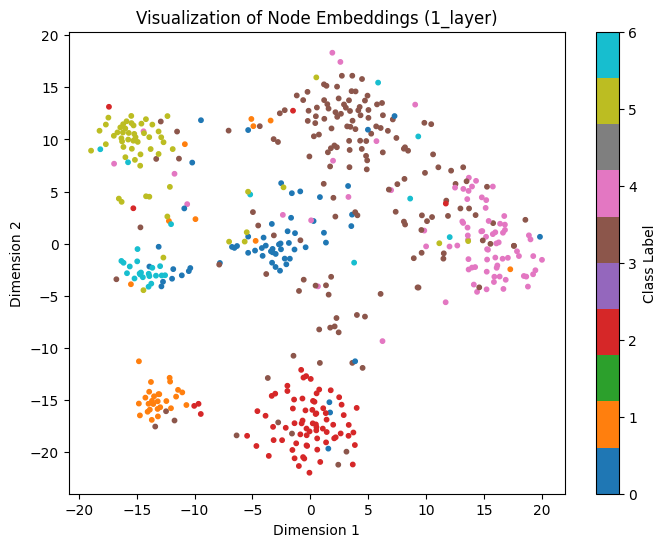

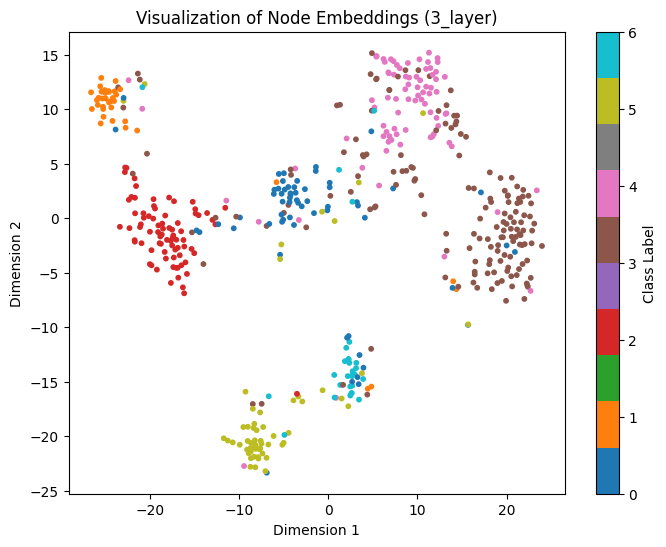

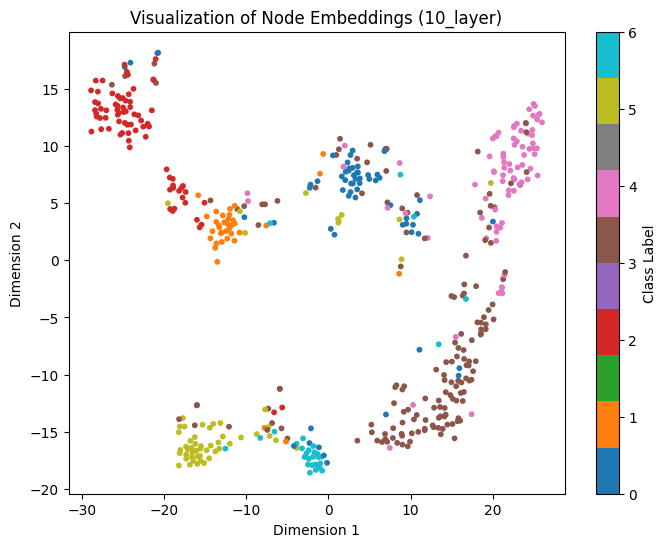

In [ ]:
visualise(feature_dict)

## Optional) Jumping Knowledge Connection

#### a. Task6) Design Graph Convolutional Network with Jumping Knowledge Connection
Define a `JumpKnowGCN` class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using `max_pooling` is recommended but you may also use other differentiable functions.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `relu` and `dropout` at the end of each layer.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class JumpKnowGCN(nn.Module):
    def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
        super(JumpKnowGCN, self).__init__()
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        self.layers = nn.ModuleList()
        if n_layers > 0:
            self.layers.append(GCNConv(input_dim, hid_dim))
            for _ in range(n_layers - 1):
                self.layers.append(GCNConv(hid_dim, hid_dim))
            self.layers.append(GCNConv(hid_dim, n_classes))
        else:
            self.fc = nn.Linear(input_dim, n_classes)

    def forward(self, X, A) -> torch.Tensor:
        if self.n_layers == 0:
            return self.fc(X)

        layer_outputs = []
        for i, layer in enumerate(self.layers[:-1]):
            X = layer(X, A)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)
            layer_outputs.append(X)

        X = torch.stack(layer_outputs, dim=0)
        X = torch.max(X, dim=0)[0]

        logits = self.layers[-1](X, A)
        return logits

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        if self.n_layers == 0:
            return self.fc(X)

        layer_outputs = []
        for i, layer in enumerate(self.layers[:-1]):
            X = layer(X, A)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)
            layer_outputs.append(X)

        X = torch.stack(layer_outputs, dim=0)
        X = torch.max(X, dim=0)[0]

        return X

    def param_init(self):
        if self.n_layers == 0:
            nn.init.xavier_uniform_(self.fc.weight)
            nn.init.zeros_(self.fc.bias)
        else:
            for layer in self.layers:
                if isinstance(layer, GCNConv):
                    nn.init.xavier_uniform_(layer.lin.weight)
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)


#### b. Repeat experiments and Visualise the embeddings

In [ ]:
torch.manual_seed(123)

In [ ]:



training_params['model_name'] = 'JumpKnowGCN'

training_params["n_layers"] = 0
model_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer = train(training_params)

training_params["n_layers"] = 3
model_3_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer = train(training_params)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1, Loss: 1.9578, Validation Accuracy: 0.1860
Epoch 2, Loss: 1.8554, Validation Accuracy: 0.2240
Epoch 3, Loss: 1.7555, Validation Accuracy: 0.2840
Epoch 4, Loss: 1.6584, Validation Accuracy: 0.3260
Epoch 5, Loss: 1.5643, Validation Accuracy: 0.3520
Epoch 6, Loss: 1.4733, Validation Accuracy: 0.3700
Epoch 7, Loss: 1.3858, Validation Accuracy: 0.3820
Epoch 8, Loss: 1.3018, Validation Accuracy: 0.4060
Epoch 9, Loss: 1.2216, Validation Accuracy: 0.4180
Epoch 10, Loss: 1.1453, Validation Accuracy: 0.4360
Epoch 11, Loss: 1.0730, Validation Accuracy: 0.4380
Epoch 12, Loss: 1.0048, Validation Accuracy: 0.4440
Epoch 13, Loss: 0.9406, Validation Accuracy: 0.4500
Epoch 14, Loss: 0.8804, Validation Accuracy: 0.4500
Epoch 15, Loss: 0.8242, Validation Accuracy: 0.4480
Epoch 16, Loss: 0.7718, Validation Accuracy: 0.4460
Epoch 17, Loss: 0.7231, Validation Accuracy: 0.4520
Epoch 18, Loss: 0.6780, Validation Accuracy: 0.4560
Epoch 19, Loss: 0.6363, Validation Accuracy: 0.4580
Epoch 20, Loss: 0.597

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

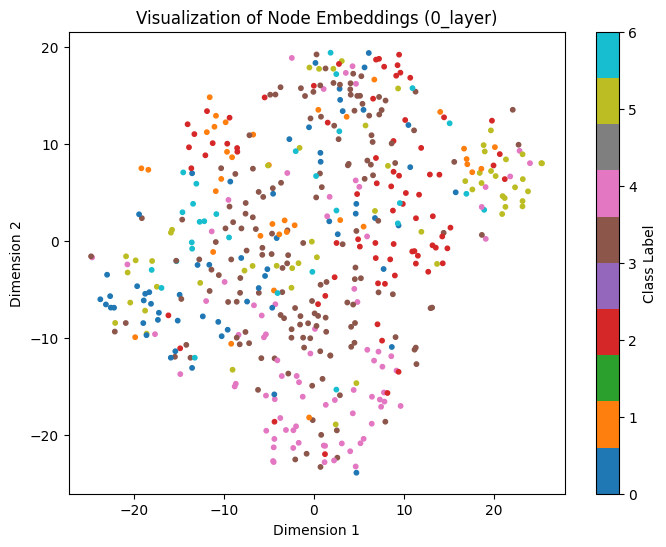

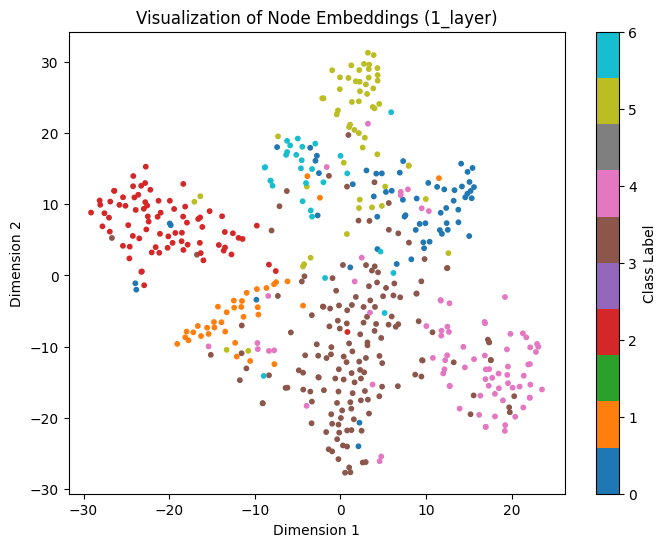

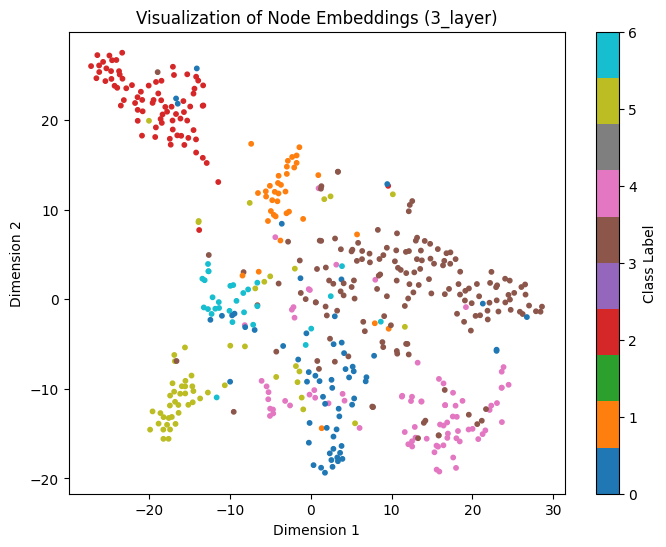

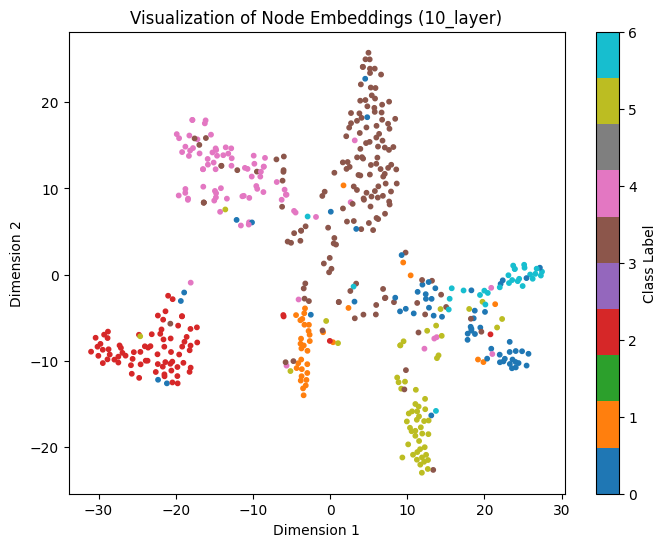

In [ ]:
visualise(feature_dict)